In [23]:
import numpy as np
import torch
import pandas as pd
import wandb
import lightning.pytorch as L
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import WandbLogger
from torch import nn, optim

from torch.utils.data import DataLoader

from fg_funcs import vae_loss, visualize_latent_space, calculate_reconstruction_quality, get_nearest_neighbors, metric, get_fg_counts, average_latent_vector, plot_average_latent_vectors, plot_distributions

In [24]:
# load the sampled data into a pandas dataframe
sampled = pd.read_pickle('chembl_35_fg_scaf_curated.pkl')

# Convert the fingerprint to numpy arrays
sampled['fingerprint_array'] = sampled['fingerprint_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((2048,), dtype=int))

In [25]:
# Create a flexible VAE model with customizable encoder/decoder hidden layers
class SimpleVAE(L.LightningModule):
    def __init__(self, input_dim, latent_dim, encoder_hidden_dims, decoder_hidden_dims):
        super(SimpleVAE, self).__init__()
        # Build encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in encoder_hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim * 2))  # Output mu and log_var
        self.encoder = nn.Sequential(*encoder_layers)

        # Build decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in decoder_hidden_dims:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())  # Assuming input is normalized between 0 and 1
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
# Create data loader
class FingerprintDataset(torch.utils.data.Dataset):
    def __init__(self, data, fingerprint_col='fingerprint_array', fg_col='fg_array'):
        self.data = data
        self.fingerprint_col = fingerprint_col
        self.fg_col = fg_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        fingerprint = torch.tensor(row[self.fingerprint_col], dtype=torch.float32)
        fg_vector = torch.tensor(row[self.fg_col], dtype=torch.float32)
        return fingerprint, fg_vector, idx
    
class SimpleVAETrainer(L.LightningModule):
    def __init__(self, input_dim, encoder_hidden_dim, decoder_hidden_dim, latent_dim, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleVAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            encoder_hidden_dims=encoder_hidden_dim,
            decoder_hidden_dims=decoder_hidden_dim
        )
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _, _ = batch
        recon_x, mu, log_var = self(x)
        beta = min(1.5, self.current_epoch / 5)  # Gradually increase beta
        loss, bce, kld = vae_loss(recon_x, x, mu, log_var, beta)
        self.log('train_loss', loss)
        self.log('train_bce', bce)
        self.log('train_kld', kld)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, _ = batch
        recon_x, mu, log_var = self(x)
        loss, bce, kld = vae_loss(recon_x, x, mu, log_var)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_bce', bce, on_epoch=True, prog_bar=True)
        self.log('val_kld', kld, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, _, _ = batch
        recon_x, mu, log_var = self(x)
        loss, bce, kld = vae_loss(recon_x, x, mu, log_var)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_bce', bce, on_epoch=True, prog_bar=True)
        self.log('test_kld', kld, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
# hyperparameters
input_dim = 2048  # Size of the fingerprint
encoder_hidden_dim = [1024, 512, 256, 128, 64]  # Size of the hidden layer
decoder_hidden_dim = [256, 1024]  # Size of the hidden layer for decoder
latent_dim = 8  # Size of the latent space
batch_size = 64  # Batch size for training
num_epochs = 15  # Number of epochs for training
learning_rate = 0.0009  # Learning rate for the optimizer

# Initialize wandb for logging
wandb_logger = WandbLogger(project='simple_vae_fingerprint', log_model=True)

# Set random seed for reproducibility
torch.manual_seed(42)

# Create training and testing dataset and data loader
train_data, test_data = train_test_split(sampled, test_size=0.2, random_state=42)
train_split, val_split = train_test_split(train_data, test_size=0.1, random_state=42)
train_dataset = FingerprintDataset(train_split)
val_dataset = FingerprintDataset(val_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = FingerprintDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the trainer
trainer = L.Trainer(max_epochs=num_epochs, val_check_interval=0.5, logger=wandb_logger)
vae_trainer = SimpleVAETrainer(input_dim, encoder_hidden_dim, decoder_hidden_dim, latent_dim, learning_rate)
trainer.fit(vae_trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)
# Evaluate the model
trainer.test(vae_trainer, test_loader)

# Finish wandb run
wandb.finish()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/damianelkins/miniconda3/envs/rdkit-thesis/lib/python3.13/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | SimpleVAE | 5.2 M  | train
--------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.645    Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/damianelkins/miniconda3/envs/rdkit-thesis/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/damianelkins/miniconda3/envs/rdkit-thesis/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0:  55%|█████▍    | 618/1125 [00:15<00:12, 39.86it/s, v_num=gdvq, val_loss=202.0, val_bce=165.0, val_kld=36.80]

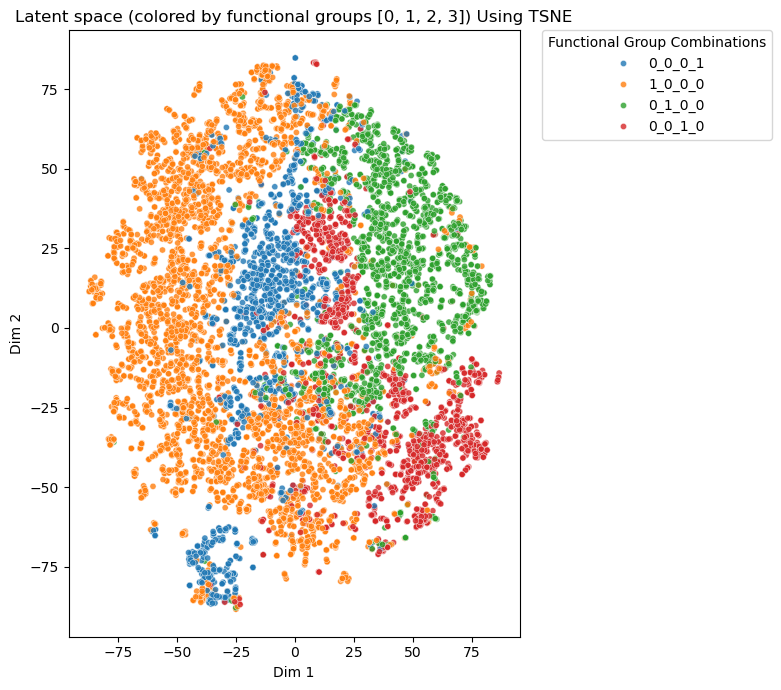

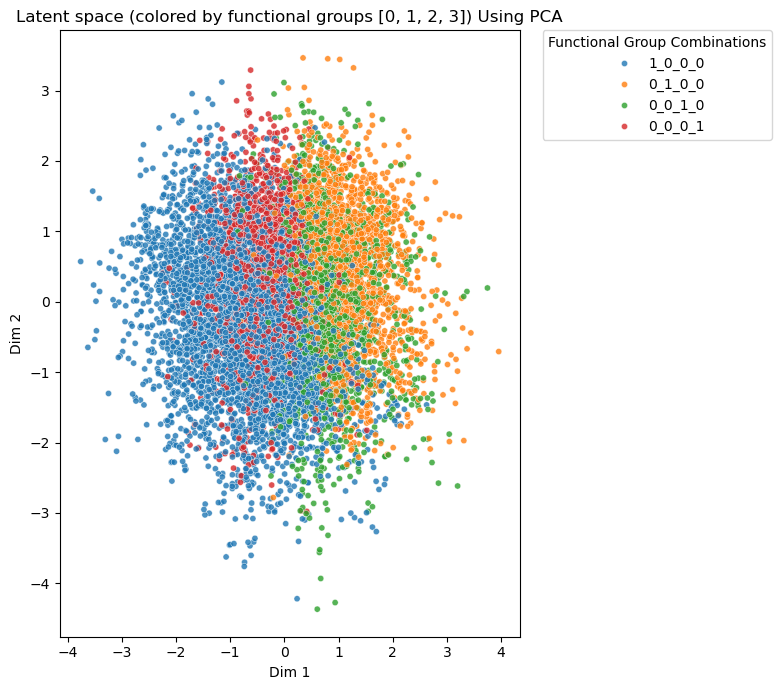

/Users/damianelkins/miniconda3/envs/rdkit-thesis/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


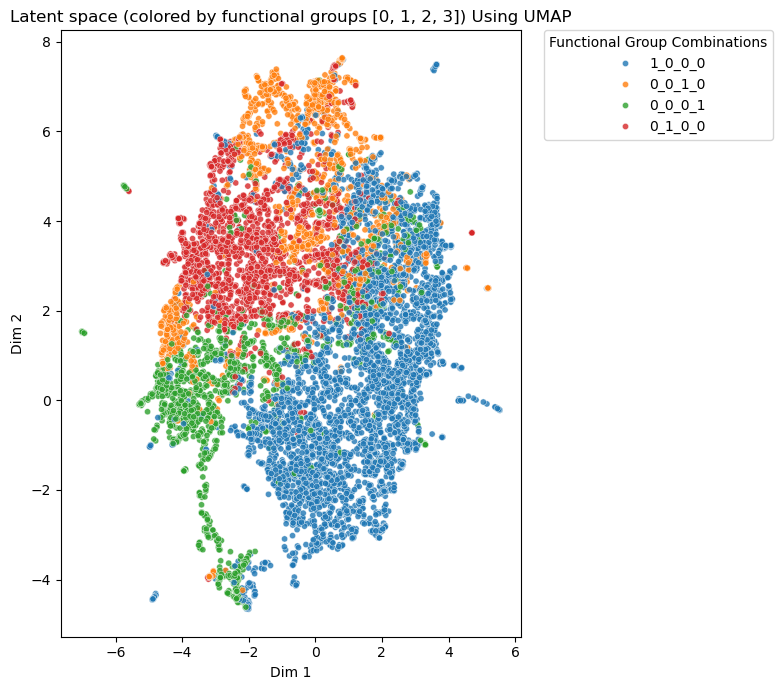

In [ ]:
visualize_latent_space(vae_trainer.model, train_dataset, fg_indicies=[0,1,2,3], method='tsne', sample_size=10000)
visualize_latent_space(vae_trainer.model, train_dataset, fg_indicies=[0,1,2,3], method='pca', sample_size=10000)
visualize_latent_space(vae_trainer.model, train_dataset, fg_indicies=[0,1,2,3], method='umap', sample_size=10000)

### TSNE/UMAP on morgan fingerprints
### Distances between fg groupings in latent space see if it aligns with current knowledge
### More investigation into the scaffolds
### Check recontrsuction quality with tanimoto, 1-weighted fscore, matthews corr

### Clustering algorithm on latent check its quality against fgs
### Run the pKa molecules through vae and check correlation
### Scan latent space with some kernel on small regions (maybe avg tanimoto similarity)

In [ ]:
# umap_embeddings = perform_umap_on_fingerprints(sampled, fingerprint_col='fingerprint_array', fg_col='fg_array', n_neighbors=15, min_dist=0.1, metric='euclidean')

In [ ]:
tanimoto_scores, f1_scores, precision_scores, recall_scores, uniqueness = calculate_reconstruction_quality(vae_trainer.model, test_dataset, threshold=0.5)
print("Tanimoto Scores:", np.mean(tanimoto_scores))
print("F1 Scores:", np.mean(f1_scores)) 
print("Precision:", np.mean(precision_scores))
print("Recall:", np.mean(recall_scores))
print("Uniqueness of reconstructions:", uniqueness)

plots = [
    {
        'data': tanimoto_scores,
        'title': 'Tanimoto Scores Distribution',
        'xlabel': 'Tanimoto Score',
    },
    {
        'data': f1_scores,
        'title': 'F1 Scores Distribution',
        'xlabel': 'F1 Score',
    },
    {
        'data': precision_scores,
        'title': 'Precision Scores Distribution',
        'xlabel': 'Precision Score',
    },
    {
        'data': recall_scores,
        'title': 'Recall Scores Distribution',
        'xlabel': 'Recall Score',
    },
]

plot_distributions(plots)

NameError: name 'calculate_reconstruction_quality' is not defined

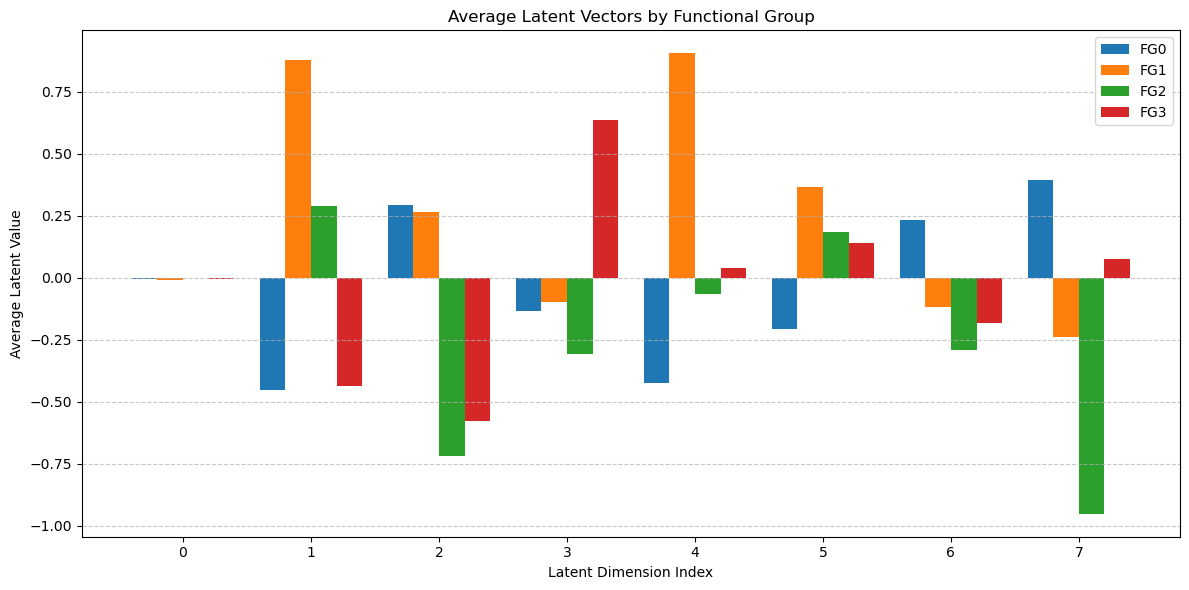

In [ ]:
avg_latents = average_latent_vector(vae_trainer.model, train_dataset, fg_col='fg_array', fg_indicies=[0, 1, 2, 3])
plot_average_latent_vectors(avg_latents)

# Organization Metric

In [ ]:
# Get nearest neighbors for the first 10 samples in the dataset
n_neighbors = 50
nbrs, latent_vectors = get_nearest_neighbors(vae_trainer.model, train_dataset, n_neighbors=n_neighbors)


# Example usage for the first 10 samples
fg_counts = get_fg_counts(train_dataset, fg_col='fg_array')
print(f"Percentage of all molecules with each functional group: {fg_counts[0]* 100:.2f}% for FG0, {fg_counts[1]* 100:.2f}% for FG1, {fg_counts[2]* 100:.2f}% for FG2, {fg_counts[3]* 100:.2f}% for FG3\n")

for i in range(10):
    metric_score = metric(nbrs, train_dataset, i, latent=latent_vectors, fg_counts=fg_counts, fg_col='fg_array', fg_indicies=[0, 1, 2, 3], n_neighbors=n_neighbors)
    print(f"Sample {i}:")
    print(f"    Metric Score: {metric_score:.2f}\n")


Functional Group Counts in Training Dataset:
[0.47568056 0.20783333 0.15794444 0.15854167]
Percentage of all molecules with each functional group: 47.57% for FG0, 20.78% for FG1, 15.79% for FG2, 15.85% for FG3

Sample 0:
    Metric Score: 2.53

Sample 1:
    Metric Score: 3.67

Sample 2:
    Metric Score: 4.81

Sample 3:
    Metric Score: 6.31

Sample 4:
    Metric Score: 2.90

Sample 5:
    Metric Score: 1.60

Sample 6:
    Metric Score: 2.10

Sample 7:
    Metric Score: 6.33

Sample 8:
    Metric Score: 0.88

Sample 9:
    Metric Score: 2.10

